In [ ]:
import gdown
import zipfile
import os
import pandas as pd
from sklearn.feature_extraction.text import TfidfVectorizer
from sklearn.model_selection import train_test_split
from sklearn.metrics import confusion_matrix, ConfusionMatrixDisplay
import tensorflow as tf
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Dense, Dropout, BatchNormalization
from tensorflow.keras.callbacks import EarlyStopping, ReduceLROnPlateau
import matplotlib.pyplot as plt


file_url = "https://drive.google.com/uc?id=12MfYQpBl_79ak9K7VHx4jDEaeFUEhHEO"
output_zip = "spam.zip"
gdown.download(file_url, output_zip, quiet=False)

with zipfile.ZipFile(output_zip, 'r') as zip_ref:
    zip_ref.extractall("spam_files")
os.remove(output_zip)


Downloading...
From: https://drive.google.com/uc?id=12MfYQpBl_79ak9K7VHx4jDEaeFUEhHEO
To: /content/spam.zip
100%|██████████| 3.58M/3.58M [00:00<00:00, 31.5MB/s]


In [ ]:
df = pd.read_csv('/content/spam_files/url_spam_classification.csv')


In [ ]:
df['is_spam'] = df['is_spam'].apply(lambda x: 1 if x == df['is_spam'].unique()[0] else 0)
df['is_spam'].unique()

array([1, 0])

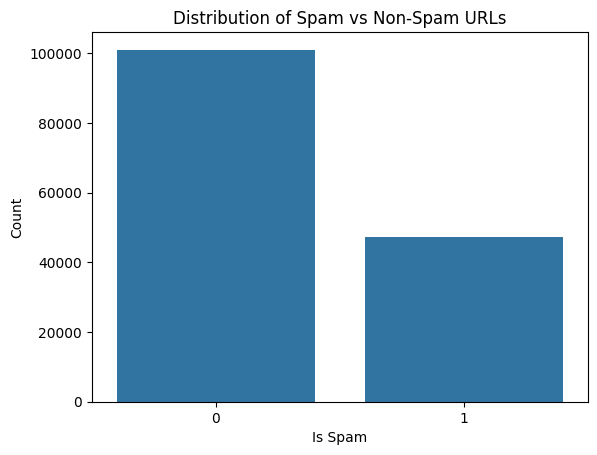

In [ ]:
import matplotlib.pyplot as plt
import seaborn as sns

# Count the distribution of 'is_spam' column
spam_distribution = df['is_spam'].value_counts()

# Plotting the distribution using seaborn
sns.barplot(x=spam_distribution.index, y=spam_distribution.values)

# Adding labels and title
plt.title('Distribution of Spam vs Non-Spam URLs')
plt.xlabel('Is Spam')
plt.ylabel('Count')

# Display the plot
plt.show()

In [ ]:
vectorizer = TfidfVectorizer(max_features=50000, ngram_range=(1, 2), lowercase=True, stop_words='english')
X = vectorizer.fit_transform(df['url'])

y = df['is_spam']
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42)

y_train = y_train.astype(int).reset_index(drop=True)
y_test = y_test.astype(int).reset_index(drop=True)


# ANN model with increased regularization
model = Sequential([
    Dense(128, activation='relu', input_dim=X_train.shape[1]),
    Dropout(0.7),
    Dense(64, activation='relu'),
    Dropout(0.7),
    Dense(32, activation='relu'),
    Dropout(0.7),
    Dense(1, activation='sigmoid')
])

model.summary()


/usr/local/lib/python3.10/dist-packages/keras/src/layers/core/dense.py:87: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(activity_regularizer=activity_regularizer, **kwargs)


Model: "sequential"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━┓
┃ Layer (type)                         ┃ Output Shape                ┃         Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━┩
│ dense (Dense)                        │ (None, 128)                 │       6,400,128 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dropout (Dropout)                    │ (None, 128)                 │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dense_1 (Dense)                      │ (None, 64)                  │           8,256 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dropout_1 (Dropout)                  │ (None, 64)                  │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dense_2 (Dense)                      │ (None, 32)                  │           2,080 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dropout_2 (Dropout)                  │ (None, 32)                  │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dense_3 (Dense)                      │ (None, 1)                   │              33 │
└──────────────────────────────────────┴─────────────────────────────┴─────────────────┘

 Total params: 6,410,497 (24.45 MB)

 Trainable params: 6,410,497 (24.45 MB)

 Non-trainable params: 0 (0.00 B)

In [ ]:
optimizer = tf.keras.optimizers.Adam(learning_rate=0.00001)
model.compile(optimizer=optimizer, loss='binary_crossentropy', metrics=['accuracy'])


early_stopping = EarlyStopping(monitor='val_loss', patience=3, restore_best_weights=True)
reduce_lr = ReduceLROnPlateau(monitor='val_loss', factor=0.2, patience=2, min_lr=0.00001)


class_weight = {0: 1.0, 1: 1.0}


In [ ]:
history = model.fit(
    X_train, y_train, epochs=3, batch_size=16,
    validation_data=(X_test, y_test),
    class_weight=class_weight, callbacks=[early_stopping, reduce_lr]
)


Epoch 1/3
7416/7416 ━━━━━━━━━━━━━━━━━━━━ 581s 78ms/step - accuracy: 0.6239 - loss: 0.6791 - val_accuracy: 0.6832 - val_loss: 0.6055 - learning_rate: 1.0000e-05
Epoch 2/3
7416/7416 ━━━━━━━━━━━━━━━━━━━━ 618s 83ms/step - accuracy: 0.6888 - loss: 0.5913 - val_accuracy: 0.8068 - val_loss: 0.4532 - learning_rate: 1.0000e-05
Epoch 3/3
7416/7416 ━━━━━━━━━━━━━━━━━━━━ 587s 79ms/step - accuracy: 0.7796 - loss: 0.4668 - val_accuracy: 0.9081 - val_loss: 0.3068 - learning_rate: 1.0000e-05


In [ ]:
from sklearn.metrics import classification_report, confusion_matrix
import numpy as np


test_loss, test_accuracy = model.evaluate(X_test, y_test)
print(f"Test Accuracy: {test_accuracy:.4f}")
print(f"Test Loss: {test_loss:.4f}")

y_pred = (model.predict(X_test) > 0.7).astype(int)


unique_classes = np.unique(y_test)


print("\nClassification Report:")
print(classification_report(y_test, y_pred, target_names=[f'Class {label}' for label in unique_classes]))


df_test = pd.DataFrame({
    'Link': [
        'https://briefingday.us8.list-manage.com/unsubs',
        'https://numlock.substack.com/subscribe',
        'https://briefingday.com/n/20200618/m#commentform',
        'https://www.youtube.com/',
        'https://www.google.com/',
        'https://hitha.substack.com/people/976632-hitha-palepu',
        'https://us3.campaign-archive.com/',
        'https://cdn.substack.com/image/fetch/f_auto,q_auto:good,fl_progressive:steep/https%3A%2F%2Fbucketeer-e05bbc84-baa3-437e-9518-adb32be77984.s3.amazonaws.com%2Fpublic%2Fimages%2Fcd5914a8-e144-4812-8e41-67e295f05007_150x25.png',
        'http://tib.matthewclifford.com/issues/tib-131-how-smart-are-politicians-why-tech-needs-some-crazy-money-religious-fundamentalism-and-the-internet-and-more-276446',
        'https://web.whatsapp.com/',
        'https://outlook.office365.com/'
    ],
    'Label': [1, 1, 0, 0, 0, 1, 1, 1, 1, 0, 0]
})


# change the threshold and experience
X_test_new = vectorizer.transform(df_test['Link'])
predictions = (model.predict(X_test_new) > 0.6).astype(int)


df_test['Predicted'] = predictions
df_test['Prediction Probability'] = model.predict(X_test_new)



print("\nPrediction Results on New Data:")
print(df_test[['Link', 'Label', 'Predicted', 'Prediction Probability']])




927/927 ━━━━━━━━━━━━━━━━━━━━ 4s 4ms/step - accuracy: 0.9088 - loss: 0.3075
Test Accuracy: 0.9081
Test Loss: 0.3068
927/927 ━━━━━━━━━━━━━━━━━━━━ 3s 3ms/step

Classification Report:
              precision    recall  f1-score   support

     Class 0       0.73      1.00      0.84     20263
     Class 1       1.00      0.19      0.32      9398

    accuracy                           0.74     29661
   macro avg       0.86      0.60      0.58     29661
weighted avg       0.81      0.74      0.68     29661

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 47ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 45ms/step

Prediction Results on New Data:
                                                 Link  Label  Predicted  \
0      https://briefingday.us8.list-manage.com/unsubs      1          1   
1              https://numlock.substack.com/subscribe      1          1   
2    https://briefingday.com/n/20200618/m#commentform      0          0   
3                            https://www.youtube.com/      0          0   
4        